In [3]:
###Required packages
import numpy as np
from hyperopt import hp, fmin, tpe
from scikits.odes.ode import ode
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

## Glucaric Acid Synthesis Model

### Model Specification

In [6]:
###Color palette
orders = ['Open Loop', 'Upstream Repression', 'Downstream Activation', 'Dual Control']
palette = {'Open Loop': sns.color_palette()[3], 'Upstream Repression': 'tab:orange', 'Downstream Activation': 'tab:green', 'Dual Control': 'tab:blue', 'Initial':'black'}

###Helper functions
def michaelismenten(x, vm, km):
    return (vm*x)/(km+x)

def reversible_michaelismenten(x, y, vm, keq, kmx, kmy):
    return (vm*(x - (y/keq)))/(x + kmx*(1+(y/kmy)))

def hilleqn(x, vm, n, km):
    return (vm*x**n)/(km**n + x**n)

def michaelismenten_substrateactivation(x, vm, km, a, ka):
    vm_eff = vm * (1+ (a*x)/(ka + x))
    return (vm_eff*x)/(km  + x)

def activation(x, k, theta, n):
    return (k*x**n)/(theta**n + x**n)
    
def repression(x, k, theta, n):
    return (k*theta**n)/(theta**n + x**n)
    
def loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2):
    loss = alpha1*j1 + alpha2*j2
    return j1, j2, loss

def name_converter(A):
    if A == ((0, 1, 0), (1, 0, 0)):
        return 'Dual Control'

    elif A == ((0, 0, 1), (0, 0, 1)):
        return 'Open Loop'

    elif A == ((0, 0, 1), (1, 0, 0)):
        return 'Downstream Activation'

    elif A == ((0, 1, 0), (0, 0, 1)):
        return 'Upstream Repression'
    else: return 'Invalid Circuit'

###Model definition
def glucaric_acid(t, y, ydot, params):

    lam = 2.7778E-05
    v_pts = 0.1656
    vm_pgi = 0.8751
    keq_pgi = 0.3
    km_pgi_g6p = 0.28
    km_pgi_f6p = 0.147
    vm_zwf = 0.0853
    km_zwf_g6p = 0.1
    vm_pfk = 2.615
    km_pfk_f6p = 0.16
    n_pfk = 3
    vm_ino1 = 0.2616
    km_ino1_g6p = 1.18
    vm_t_mi = 0.045
    km_t_mi = 15
    vm_miox = 0.2201
    km_miox_mi = 24.7
    a_miox = 5.4222
    ka_miox_mi = 20


    g6p, f6p, mi, ino1, miox, j1, j2 = y

    A, W = params 

    n_ino1, theta_ino1, k_ino1 = W[0]
    n_miox, theta_miox, k_miox = W[1]

    v_pgi = reversible_michaelismenten(g6p, f6p, vm_pgi, keq_pgi, km_pgi_g6p, km_pgi_f6p)
    v_zwf = michaelismenten(g6p, vm_zwf, km_zwf_g6p)
    v_pfk = hilleqn(f6p, vm_pfk, n_pfk, km_pfk_f6p)
    v_ino1 = ino1 * michaelismenten(g6p, vm_ino1, km_ino1_g6p)
    v_tm = michaelismenten(mi, vm_t_mi, km_t_mi)
    v_miox = miox * michaelismenten_substrateactivation(mi, vm_miox, km_miox_mi, a_miox, ka_miox_mi)

    u_ino1_mi = np.sum(A[0]*np.array([activation(mi, k_ino1, theta_ino1, n_ino1), repression(mi, k_ino1, theta_ino1, n_ino1), k_ino1]))
    u_miox_mi = np.sum(A[1]*np.array([activation(mi, k_miox, theta_miox, n_miox), repression(mi, k_miox, theta_miox, n_miox), k_miox]))

    ydot[0] = v_pts - v_zwf - v_pgi - lam*g6p
    ydot[1] = v_pgi + 0.5*v_zwf - v_pfk - lam*f6p
    ydot[2] = v_ino1 - v_tm - v_miox - lam*mi
    ydot[3] = u_ino1_mi  - lam*ino1
    ydot[4] = u_miox_mi - lam*miox
    ydot[5] = (v_pts - v_miox)**2
    ydot[6] = u_ino1_mi + u_miox_mi

###Define search space
space = hp.choice('architecture', 
    [([[0, 0, 1], [1, 0, 0]], [[2., hp.uniform('theta1_da', 1E-7, 10), hp.uniform('k1_da', 1E-7, 5)], [2., hp.uniform('theta2_da', 1E-7, 10), hp.uniform('k2_da', 1E-7, 5)]]),
     ([[0, 1, 0], [0, 0, 1]], [[2., hp.uniform('theta1_ur', 1E-7, 10), hp.uniform('k1_ur', 1E-7, 5)], [2., hp.uniform('theta2_ur', 1E-7, 10), hp.uniform('k2_ur', 1E-7, 5)]]),
     ([[0, 0, 1], [0, 0, 1]], [[2., hp.uniform('theta1_nc', 1E-7, 10), hp.uniform('k1_nc', 1E-7, 5)], [2., hp.uniform('theta2_nc', 1E-7, 10), hp.uniform('k2_nc', 1E-7, 5)]]),
     ([[0, 1, 0], [1, 0, 0]], [[2., hp.uniform('theta1_dc', 1E-7, 10), hp.uniform('k1_dc', 1E-7, 5)], [2., hp.uniform('theta2_dc', 1E-7, 10), hp.uniform('k2_dc', 1E-7, 5)]])])

###Objective function
def run_hyperopt(max_iters):
    losses = []
    params = []
    circuits = []

    #Define objective function
    def objective(args):
        architecture, param_values = args
        #Integration conditions
        t = np.linspace(0, 5E5, 200) 
        y0 = np.array([0.281, 0.0605, 0., 0., 0. , 0., 0.]) #g6p, f6p, mi, ino1, miox

        extra_options = {'old_api': False, 'user_data': [architecture, param_values], 'rtol':1E-4}
        ode_solver = ode('cvode', glucaric_acid, **extra_options)
        solution = ode_solver.solve(t, y0)
        j1, j2 = solution.values.y[-1, -2:]
        j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-3)
        losses.append(loss)
        params.append(param_values)
        circuits.append(architecture)
        return loss
    

    #Run hyperopt call
    best = fmin(objective, space, algo=tpe.suggest, max_evals=max_iters)
    #Create trajectory data frame
    landscape = pd.DataFrame({'circuit':circuits, 'loss': losses, 'k1': [params[i][0][2] for i in range(len(params))], 'k2': [params[i][1][2] for i in range(len(params))], 'theta1': [params[i][0][1] for i in range(len(params))], 'theta2': [params[i][1][1] for i in range(len(params))]})  
    landscape['Circuit'] = [name_converter(landscape.circuit[i]) for i in range(len(landscape))]
    landscape = landscape.reset_index()

    best_loss = 1E5
    best_circuit = 'Initial'
    best_losses = []
    best_losses_circuits = []
    for i in range(len(landscape)):
        if landscape.loss[i] < best_loss:
            best_loss = landscape.loss[i]
            best_circuit = landscape.Circuit[i]
        best_losses.append(best_loss)
        best_losses_circuits.append(best_circuit)
    landscape['best_losses'] = best_losses
    landscape['best_loss_circuit'] = best_losses_circuits

    return landscape, best

### Simulation Experiments

In [25]:
###Run sample optimization
max_iters = 10
landscape, best = run_hyperopt(max_iters)
#landscape.to_csv('sample_run.csv')

100%|██████████| 10/10 [00:00<00:00, 32.20trial/s, best loss: 2405589.147505963]


In [ ]:
###Explore kinetic perturbations - VERY TIME CONSUMING
global perturbs
max_iters = 1000
total_landscape =  pd.DataFrame()
total_perturbs = lhs(3, samples=1000)
for p in total_perturbs:
    perturbs = p
    space = hp.choice('architecture', 
    [([[0, 0, 1], [1, 0, 0]], [[2., hp.uniform('theta1_da', 1E-7, 10), hp.uniform('k1_da', 1E-7, 5)], [2., hp.uniform('theta2_da', 1E-7, 10), hp.uniform('k2_da', 1E-7, 5)]])])
    da_landscape, best = run_hyperopt(max_iters)

    space = hp.choice('architecture', 
    [([[0, 1, 0], [0, 0, 1]], [[2., hp.uniform('theta1_ur', 1E-7, 10), hp.uniform('k1_ur', 1E-7, 5)], [2., hp.uniform('theta2_ur', 1E-7, 10), hp.uniform('k2_ur', 1E-7, 5)]])])
    ur_landscape, best = run_hyperopt(max_iters)

    space = hp.choice('architecture', 
    [([[0, 0, 1], [0, 0, 1]], [[2., hp.uniform('theta1_nc', 1E-7, 10), hp.uniform('k1_nc', 1E-7, 5)], [2., hp.uniform('theta2_nc', 1E-7, 10), hp.uniform('k2_nc', 1E-7, 5)]])])
    nc_landscape, best = run_hyperopt(max_iters)

    space = hp.choice('architecture', 
    [([[0, 1, 0], [1, 0, 0]], [[2., hp.uniform('theta1_dc', 1E-7, 10), hp.uniform('k1_dc', 1E-7, 5)], [2., hp.uniform('theta2_dc', 1E-7, 10), hp.uniform('k2_dc', 1E-7, 5)]])])
    dc_landscape, best = run_hyperopt(max_iters)

    landscape = pd.concat([dc_landscape, nc_landscape, ur_landscape, da_landscape])
    total_landscape = pd.concat([total_landscape, landscape])
    landscape.to_csv('kinetic_perturbation.csv', mode='a')
    
total_landscape.to_csv('kinetic_perturbation_total.csv')

In [ ]:
###Explore growth conditions robustness 
global perturbs
max_iters = 1000
total_landscape = pd.DataFrame()
total_perturbs = lhs(2, samples=500)
for p in total_perturbs:
    perturbs = p
    space = hp.choice('architecture', 
    [([[0, 1, 0], [0, 0, 1]], [[2., hp.uniform('theta1_ur', 1E-7, 10), hp.uniform('k1_ur', 1E-7, 5)], [2., hp.uniform('theta2_ur', 1E-7, 10), hp.uniform('k2_ur', 1E-7, 5)]])])
    ur_landscape, best = run_hyperopt(max_iters)

    space = hp.choice('architecture', 
    [([[0, 0, 1], [1, 0, 0]], [[2., hp.uniform('theta1_da', 1E-7, 10), hp.uniform('k1_da', 1E-7, 5)], [2., hp.uniform('theta2_da', 1E-7, 10), hp.uniform('k2_da', 1E-7, 5)]])])
    da_landscape, best = run_hyperopt(max_iters)

    space = hp.choice('architecture', 
    [([[0, 1, 0], [1, 0, 0]], [[2., hp.uniform('theta1_dc', 1E-7, 10), hp.uniform('k1_dc', 1E-7, 5)], [2., hp.uniform('theta2_dc', 1E-7, 10), hp.uniform('k2_dc', 1E-7, 5)]])])
    dc_landscape, best = run_hyperopt(max_iters)

    space = hp.choice('architecture', 
    [([[0, 0, 1], [0, 0, 1]], [[2., hp.uniform('theta1_nc', 1E-7, 10), hp.uniform('k1_nc', 1E-7, 5)], [2., hp.uniform('theta2_nc', 1E-7, 10), hp.uniform('k2_nc', 1E-7, 5)]])])
    nc_landscape, best = run_hyperopt(max_iters)

    landscape = pd.concat([ur_landscape, da_landscape, dc_landscape, nc_landscape])
    landscape['perturb0'] = p[0]
    landscape['perturb1'] = p[1]
    landscape.to_csv('growth_condition_robustness1.csv', mode='a', header=False)
    total_landscape = pd.concat([total_landscape, landscape])

total_landscape.to_csv('growth_conditions_robustness_backup1.csv')

In [ ]:
###Explore growth conditions robustness - 1D sweep
global perturbs
max_iters = 1000
total_landscape = pd.DataFrame()
total_perturbs = np.linspace(0.5, 2, 101)
for p in total_perturbs:
    perturbs = [p, 1.]
    space = hp.choice('architecture', 
    [([[0, 1, 0], [0, 0, 1]], [[2., hp.uniform('theta1_ur', 1E-7, 10), hp.uniform('k1_ur', 1E-7, 5)], [2., hp.uniform('theta2_ur', 1E-7, 10), hp.uniform('k2_ur', 1E-7, 5)]])])
    ur_landscape, best = run_hyperopt(max_iters)

    space = hp.choice('architecture', 
    [([[0, 0, 1], [1, 0, 0]], [[2., hp.uniform('theta1_da', 1E-7, 10), hp.uniform('k1_da', 1E-7, 5)], [2., hp.uniform('theta2_da', 1E-7, 10), hp.uniform('k2_da', 1E-7, 5)]])])
    da_landscape, best = run_hyperopt(max_iters)

    space = hp.choice('architecture', 
    [([[0, 1, 0], [1, 0, 0]], [[2., hp.uniform('theta1_dc', 1E-7, 10), hp.uniform('k1_dc', 1E-7, 5)], [2., hp.uniform('theta2_dc', 1E-7, 10), hp.uniform('k2_dc', 1E-7, 5)]])])
    dc_landscape, best = run_hyperopt(max_iters)

    space = hp.choice('architecture', 
    [([[0, 0, 1], [0, 0, 1]], [[2., hp.uniform('theta1_nc', 1E-7, 10), hp.uniform('k1_nc', 1E-7, 5)], [2., hp.uniform('theta2_nc', 1E-7, 10), hp.uniform('k2_nc', 1E-7, 5)]])])
    nc_landscape, best = run_hyperopt(max_iters)

    landscape = pd.concat([ur_landscape, da_landscape, dc_landscape, nc_landscape])
    landscape['perturbation'] = p
    landscape.to_csv('gc_influx.csv', mode='a', header=False)
    total_landscape = pd.concat([total_landscape, landscape])

total_landscape.to_csv('gc_influx_total.csv')

In [ ]:
###Explore growth conditions robustness - 1D sweep
global perturbs
max_iters = 1000
total_landscape = pd.DataFrame()
total_perturbs = np.linspace(0.5, 2, 101)
for p in total_perturbs:
    perturbs = [1., p]
    space = hp.choice('architecture', 
    [([[0, 1, 0], [0, 0, 1]], [[2., hp.uniform('theta1_ur', 1E-7, 10), hp.uniform('k1_ur', 1E-7, 5)], [2., hp.uniform('theta2_ur', 1E-7, 10), hp.uniform('k2_ur', 1E-7, 5)]])])
    ur_landscape, best = run_hyperopt(max_iters)

    space = hp.choice('architecture', 
    [([[0, 0, 1], [1, 0, 0]], [[2., hp.uniform('theta1_da', 1E-7, 10), hp.uniform('k1_da', 1E-7, 5)], [2., hp.uniform('theta2_da', 1E-7, 10), hp.uniform('k2_da', 1E-7, 5)]])])
    da_landscape, best = run_hyperopt(max_iters)

    space = hp.choice('architecture', 
    [([[0, 1, 0], [1, 0, 0]], [[2., hp.uniform('theta1_dc', 1E-7, 10), hp.uniform('k1_dc', 1E-7, 5)], [2., hp.uniform('theta2_dc', 1E-7, 10), hp.uniform('k2_dc', 1E-7, 5)]])])
    dc_landscape, best = run_hyperopt(max_iters)

    space = hp.choice('architecture', 
    [([[0, 0, 1], [0, 0, 1]], [[2., hp.uniform('theta1_nc', 1E-7, 10), hp.uniform('k1_nc', 1E-7, 5)], [2., hp.uniform('theta2_nc', 1E-7, 10), hp.uniform('k2_nc', 1E-7, 5)]])])
    nc_landscape, best = run_hyperopt(max_iters)

    landscape = pd.concat([ur_landscape, da_landscape, dc_landscape, nc_landscape])
    landscape['perturbation'] = p
    landscape.to_csv('gc_export.csv', mode='a', header=False)
    total_landscape = pd.concat([total_landscape, landscape])

total_landscape.to_csv('gc_export_total.csv')

In [26]:
###Run hyperopt 100 times to solve for background
max_iters = 1000
total_background =  pd.DataFrame()
perturbs = [1., 1., 1.]
for i in range(100):
    space = hp.choice('architecture', 
    [([[0, 0, 1], [1, 0, 0]], [[2., hp.uniform('theta1_da', 1E-7, 10), hp.uniform('k1_da', 1E-7, 5)], [2., hp.uniform('theta2_da', 1E-7, 10), hp.uniform('k2_da', 1E-7, 5)]])])
    da_landscape, best = run_hyperopt(max_iters)

    space = hp.choice('architecture', 
    [([[0, 1, 0], [0, 0, 1]], [[2., hp.uniform('theta1_ur', 1E-7, 10), hp.uniform('k1_ur', 1E-7, 5)], [2., hp.uniform('theta2_ur', 1E-7, 10), hp.uniform('k2_ur', 1E-7, 5)]])])
    ur_landscape, best = run_hyperopt(max_iters)

    space = hp.choice('architecture', 
    [([[0, 0, 1], [0, 0, 1]], [[2., hp.uniform('theta1_nc', 1E-7, 10), hp.uniform('k1_nc', 1E-7, 5)], [2., hp.uniform('theta2_nc', 1E-7, 10), hp.uniform('k2_nc', 1E-7, 5)]])])
    nc_landscape, best = run_hyperopt(max_iters)

    space = hp.choice('architecture', 
    [([[0, 1, 0], [1, 0, 0]], [[2., hp.uniform('theta1_dc', 1E-7, 10), hp.uniform('k1_dc', 1E-7, 5)], [2., hp.uniform('theta2_dc', 1E-7, 10), hp.uniform('k2_dc', 1E-7, 5)]])])
    dc_landscape, best = run_hyperopt(max_iters)

    background = pd.concat([dc_landscape, nc_landscape, ur_landscape, da_landscape])
    total_background = pd.concat([total_background, background])
    #background.to_csv('background.csv', mode='a')
    
total_background.to_csv('background_total.csv')

 54%|█████▎    | 537/1000 [00:24<00:19, 23.41trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1920.1, mxstep steps taken before reaching tout.



 71%|███████   | 708/1000 [00:33<00:15, 19.11trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 582.136, mxstep steps taken before reaching tout.



 91%|█████████ | 908/1000 [00:35<00:03, 24.10trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 1551.37, mxstep steps taken before reaching tout.



 61%|██████▏   | 614/1000 [00:21<00:15, 24.45trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1601.05, mxstep steps taken before reaching tout.



 27%|██▋       | 267/1000 [00:09<00:33, 21.98trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2117.59, mxstep steps taken before reaching tout.



 20%|█▉        | 199/1000 [00:07<00:31, 25.54trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1709.24, mxstep steps taken before reaching tout.



 16%|█▌        | 162/1000 [00:06<00:31, 26.53trial/s, best loss: 0.0]              


[CVODE ERROR]  CVode
  At t = 515.543, mxstep steps taken before reaching tout.



 51%|█████     | 511/1000 [00:20<00:20, 23.73trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2374.87, mxstep steps taken before reaching tout.



 18%|█▊        | 181/1000 [00:08<00:33, 24.26trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1927.03, mxstep steps taken before reaching tout.



 71%|███████   | 708/1000 [00:29<00:12, 22.48trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1695.11, mxstep steps taken before reaching tout.



  2%|▏         | 17/1000 [00:00<00:37, 26.24trial/s, best loss: 0.0]             


[CVODE ERROR]  CVode
  At t = 1729.1, mxstep steps taken before reaching tout.



 55%|█████▍    | 548/1000 [00:25<00:24, 18.42trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1566.56, mxstep steps taken before reaching tout.



 56%|█████▌    | 555/1000 [00:26<00:23, 18.79trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 479.186, mxstep steps taken before reaching tout.



 30%|██▉       | 296/1000 [00:11<00:27, 25.16trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2109, mxstep steps taken before reaching tout.



  2%|▏         | 15/1000 [00:00<00:33, 29.06trial/s, best loss: 0.0]             


[CVODE ERROR]  CVode
  At t = 957.664, mxstep steps taken before reaching tout.



 48%|████▊     | 481/1000 [00:19<00:24, 20.84trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2022.89, mxstep steps taken before reaching tout.



 13%|█▎        | 127/1000 [00:05<00:33, 26.20trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1980.59, mxstep steps taken before reaching tout.


[CVODE ERROR]  CVode
  At t = 538.045, mxstep steps taken before reaching tout.



  8%|▊         | 84/1000 [00:03<00:37, 24.60trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2384.92, mxstep steps taken before reaching tout.



 45%|████▌     | 452/1000 [00:22<00:30, 18.02trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2444.52, mxstep steps taken before reaching tout.



 31%|███       | 309/1000 [00:12<00:40, 17.01trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 491.208, mxstep steps taken before reaching tout.



  5%|▌         | 53/1000 [00:02<00:39, 24.04trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2257.11, mxstep steps taken before reaching tout.



  8%|▊         | 84/1000 [00:03<00:46, 19.51trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1554.43, mxstep steps taken before reaching tout.



 89%|████████▉ | 894/1000 [00:40<00:05, 19.83trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1113.27, mxstep steps taken before reaching tout.



 77%|███████▋  | 770/1000 [00:44<00:13, 16.72trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1050.11, mxstep steps taken before reaching tout.



 76%|███████▌  | 756/1000 [00:33<00:11, 20.57trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 638.491, mxstep steps taken before reaching tout.



 10%|█         | 102/1000 [00:03<00:35, 25.11trial/s, best loss: 0.0]              


[CVODE ERROR]  CVode
  At t = 1686.15, mxstep steps taken before reaching tout.



 98%|█████████▊| 976/1000 [00:41<00:01, 20.82trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2181.64, mxstep steps taken before reaching tout.



 11%|█         | 111/1000 [00:03<00:34, 26.07trial/s, best loss: 0.0]              


[CVODE ERROR]  CVode
  At t = 652.064, mxstep steps taken before reaching tout.



 73%|███████▎  | 734/1000 [00:31<00:12, 20.49trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2314.73, mxstep steps taken before reaching tout.



 97%|█████████▋| 968/1000 [01:08<00:02, 13.97trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1772.48, mxstep steps taken before reaching tout.



 15%|█▌        | 154/1000 [00:09<00:44, 19.10trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1385.51, mxstep steps taken before reaching tout.



  3%|▎         | 32/1000 [00:01<00:38, 24.91trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2249.24, mxstep steps taken before reaching tout.



 74%|███████▍  | 745/1000 [00:31<00:12, 21.00trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2322.46, mxstep steps taken before reaching tout.



 91%|█████████ | 909/1000 [00:35<00:04, 22.38trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 628.076, mxstep steps taken before reaching tout.



 67%|██████▋   | 674/1000 [00:25<00:13, 23.91trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 1742.64, mxstep steps taken before reaching tout.



 13%|█▎        | 132/1000 [00:05<00:33, 25.96trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2258.65, mxstep steps taken before reaching tout.



 13%|█▎        | 127/1000 [00:04<00:33, 25.84trial/s, best loss: 0.0]              


[CVODE ERROR]  CVode
  At t = 1553.93, mxstep steps taken before reaching tout.



 99%|█████████▉| 993/1000 [00:39<00:00, 22.90trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 2208.46, mxstep steps taken before reaching tout.



 36%|███▋      | 364/1000 [00:13<00:24, 26.01trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1285.12, mxstep steps taken before reaching tout.



  7%|▋         | 68/1000 [00:02<00:33, 28.22trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1825.32, mxstep steps taken before reaching tout.



  3%|▎         | 28/1000 [00:00<00:33, 29.39trial/s, best loss: 0.0]              


[CVODE ERROR]  CVode
  At t = 1601.98, mxstep steps taken before reaching tout.



 19%|█▉        | 191/1000 [00:07<00:31, 25.95trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1419.66, mxstep steps taken before reaching tout.



 44%|████▍     | 444/1000 [00:16<00:22, 24.92trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 1959.73, mxstep steps taken before reaching tout.



 92%|█████████▏| 921/1000 [00:38<00:03, 21.19trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 1320.17, mxstep steps taken before reaching tout.



 96%|█████████▌| 961/1000 [00:40<00:01, 20.68trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 2239.05, mxstep steps taken before reaching tout.



 73%|███████▎  | 730/1000 [00:29<00:11, 24.10trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2100.67, mxstep steps taken before reaching tout.



 10%|▉         | 96/1000 [00:02<00:25, 35.50trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1470.89, mxstep steps taken before reaching tout.



 52%|█████▏    | 523/1000 [00:14<00:14, 32.24trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1735.78, mxstep steps taken before reaching tout.



 17%|█▋        | 170/1000 [00:04<00:21, 38.35trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 2173.25, mxstep steps taken before reaching tout.



  7%|▋         | 68/1000 [00:01<00:25, 36.76trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1256.28, mxstep steps taken before reaching tout.



 10%|█         | 104/1000 [00:02<00:24, 36.29trial/s, best loss: 0.0]              


[CVODE ERROR]  CVode
  At t = 1788.12, mxstep steps taken before reaching tout.



100%|██████████| 1000/1000 [00:28<00:00, 34.86trial/s, best loss: 0.0]


### Visualization

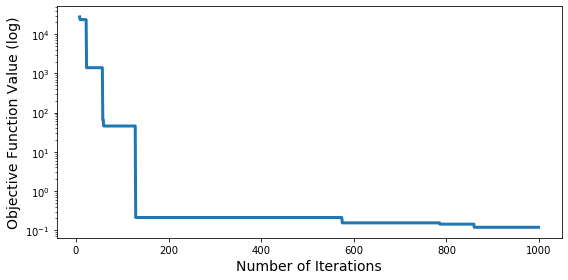

In [13]:
####FIGURE: Sample loss descent
landscape = pd.read_csv('sample_run.csv')
fig, ax = plt.subplots(1,1,figsize=(8, 4))
prev_c = 'Initial'
starts = []
archs = [prev_c]
for i in range(len(landscape)):
    c = landscape.best_loss_circuit[i]
    if c != prev_c: 
        starts.append(i)
        archs.append(c)
        prev_c = c
starts
stops = starts[1:]
stops.append(len(landscape))

for start, stop, a in zip(starts, stops, archs[1:]):
    ax.plot(landscape.index[start:stop+1], landscape.best_losses[start:stop+1], color=palette[a], linewidth=3)
ax.set_ylabel('Objective Function Value (log)', fontsize=14)
ax.set_yscale('log')
ax.set_xlabel('Number of Iterations', fontsize=14)

fig.tight_layout()
fig.savefig('sample_loss_descent.png', dpi=300)

/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/seaborn/relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)


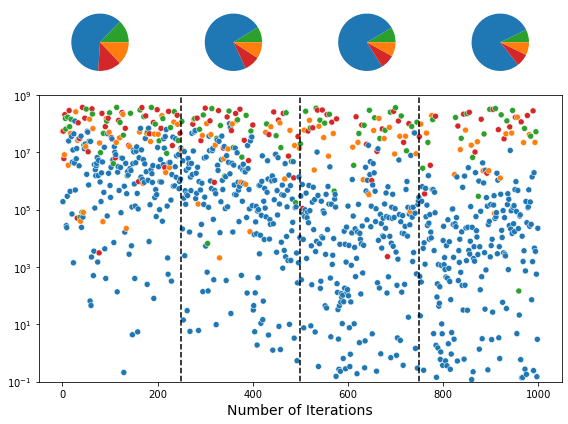

In [14]:
####FIGURE: Sample loss scatter and pie
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(nrows=2, ncols=4, height_ratios=[1, 4], width_ratios=[1, 1, 1, 1])

ax = fig.add_subplot(gs[1, :])
ax.set_xlabel('Number of Iterations', fontsize=14)
ax.set_yscale('log')
ax.set_ylim([10E-2, 10E8])
sns.scatterplot(x='index', y='loss', hue='Circuit', data=landscape, ax=ax, hue_order=orders, palette=palette, legend=False)
ax.vlines(250, 0, 10E9, linestyles='dashed')
ax.vlines(500, 0, 10E9, linestyles='dashed')
ax.vlines(750, 0, 10E9, linestyles='dashed')
ax.set_ylabel(None)


quarter1 = (landscape.iloc[0:250].sort_values(by='Circuit').groupby('Circuit').count().loss/250).reset_index()
quarter2 = (landscape.iloc[250:500].sort_values(by='Circuit').groupby('Circuit').count().loss/250).reset_index()
quarter3 = (landscape.iloc[500:750].sort_values(by='Circuit').groupby('Circuit').count().loss/250).reset_index()
quarter4 = (landscape.iloc[750:1000].sort_values(by='Circuit').groupby('Circuit').count().loss/250).reset_index()
colors = ['tab:green', 'tab:blue', sns.color_palette()[3],  'tab:orange']

ax = fig.add_subplot(gs[0, 0])
ax.pie(quarter1.loss, colors=colors)

ax = fig.add_subplot(gs[0, 1])
ax.pie(quarter2.loss, colors=colors)

ax = fig.add_subplot(gs[0, 2])
ax.pie(quarter3.loss, colors=colors)

ax = fig.add_subplot(gs[0, 3])
ax.pie(quarter4.loss, colors=colors)

fig.tight_layout()
fig.savefig('sample_loss_scatter_pie.png', dpi=300)

In [15]:
#Postprocessing on landscape
kinetic_perturbation = pd.read_csv('kinetic_perturbation_total.csv')
#Recompute best loss on non-error samples
start=0
stop=1000
new_total_landscape = pd.DataFrame()
for j in range(500*4):
    landscape = kinetic_perturbation.iloc[start:stop].reset_index(drop=True)
    best_loss = 1E9
    best_circuit = 'Initial'
    best_losses = []
    best_losses_circuits = []
    for i in range(len(landscape)):
        if landscape.loss[i] < best_loss and landscape.loss[i] != 0:
            best_loss = landscape.loss[i]
            best_circuit = landscape.circuit[i]
        best_losses.append(best_loss)
        best_losses_circuits.append(best_circuit)
    landscape['best_losses'] = best_losses
    landscape['best_loss_circuit'] = best_losses_circuits 
    new_total_landscape = pd.concat([new_total_landscape, landscape])
    start = stop
    stop += 1000
kinetic_perturbation = new_total_landscape.loc[new_total_landscape.loss != 0]

#Read in background
total_background = pd.read_csv('background.csv')
plot_landscape = kinetic_perturbation.loc[kinetic_perturbation.index==999]

FileNotFoundError: [Errno 2] No such file or directory: 'kinetic_perturbation_total.csv'

#### Analysis of Kinetic Perturbation

NameError: name 'total_background' is not defined

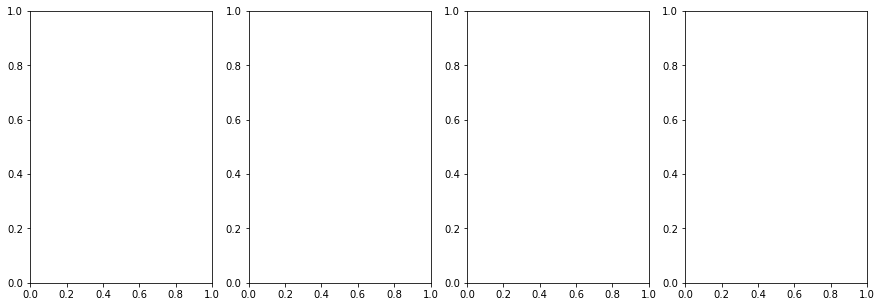

In [12]:
### Figure: Mean loss by architecture
fig, axs = plt.subplots(1,4,figsize=(15, 5))
palettes = ['Reds', 'Oranges', 'Greens', 'Blues']

for i in range(4):
    c = orders[i]
    da_background = total_background.loc[total_background.Circuit == c].loc[total_background['index'] == 999]
    da_landscape =  plot_landscape.loc[plot_landscape.Circuit == c]

    plot_data = pd.DataFrame({'best_loss': da_landscape.best_losses.to_list(), 'type':'Perturbed'})
    plot_data = pd.concat([plot_data, pd.DataFrame({'best_loss':da_background.best_losses.to_list(), 'type':'Background' })])
    
    ax = axs[i]
    sns.barplot(data=plot_data, y='best_loss', x='type', palette=palettes[i], ax=ax)
    ax.set_ylabel('Best Objective Function Value Achieved', fontsize=14)
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelsize=14)

    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])

    if i != 0:  
        ax.set_ylabel('')

axs[0].set_yticks([0, 2, 4, 6, 8, 10])
axs[1].set_yticks([0.25, 0.5, 0.75, 1.0, 1.25, 1.5])
axs[2].set_yticks([0.25, 0.5, 0.75, 1.0, 1.25, 1.5])
axs[3].set_yticks([0.025, 0.05, 0.075, 0.1, 0.125, 0.15])

fig.text(0.11, -0.02, 'Open Loop                                   Upstream Repression                      Downstream Activation                               Dual Control', ha='left', fontsize=14)
fig.add_artist(Line2D([0.04, 1], [0.05, 0.05], color='k', linewidth=1))

fig.tight_layout()
fig.savefig('kinetic_perturbation_loss_bar.png', dpi=300, pad_inches=1)

NameError: name 'total_background' is not defined

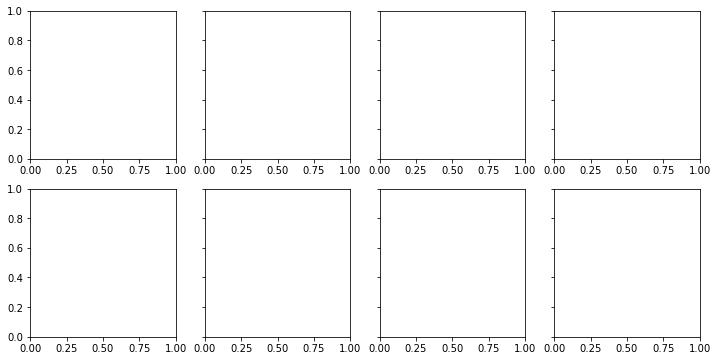

In [11]:
### Figure: Box plots of parameter values 
fig, axs = plt.subplots(2,4,figsize=(12, 6), sharey='row')
palettes = ['Reds', 'Oranges', 'Greens', 'Blues']
params = ['k1', 'theta1', 'k2', 'theta2']
param_names = ['$k_1$', r'$\theta_1$', '$k_2$', r'$\theta_2$']
for i in range(4):
    c = orders[i]
    background = total_background.loc[total_background.Circuit == c].loc[total_background['index'] == 999]
    landscape =  plot_landscape.loc[plot_landscape.Circuit == c]
    plot_data = pd.concat([pd.DataFrame({'param':landscape.k1.to_list(), 'type':'Perturbed', 'name': param_names[0]}), pd.DataFrame({'param': landscape.theta1.to_list(), 'type':'Perturbed', 'name': param_names[1]}), pd.DataFrame({'param': landscape.k2.to_list(), 'type':'Perturbed', 'name': param_names[2]}), pd.DataFrame({'param': landscape.theta2.to_list(), 'type':'Perturbed', 'name': param_names[3]})])
    plot_background = pd.concat([pd.DataFrame({'param':background.k1.to_list(), 'type':'Background', 'name': param_names[0]}), pd.DataFrame({'param': background.theta1.to_list(), 'type':'Background', 'name': param_names[1]}), pd.DataFrame({'param': background.k2.to_list(), 'type':'Background', 'name': param_names[2]}), pd.DataFrame({'param': background.theta2.to_list(), 'type':'Background', 'name': param_names[3]})])
    plot_data = pd.concat([plot_data, plot_background])

    for j in range(2):
        if j == 0:
            subset = plot_data.loc[plot_data.name.isin([param_names[0], param_names[2]])]
        else:
            subset = plot_data.loc[plot_data.name.isin([param_names[1], param_names[3]])] 
        ax = axs[j][i]
        sns.boxplot(data=subset, y='param', x='name', hue='type', palette=palettes[i], ax=ax, dodge=True)
        ax.legend([], [], frameon=False)
        ax.set_ylabel(param_names[i], fontsize=14)
        ax.set_xlabel('')
        ax.tick_params(axis='x', labelsize=14)

        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        if i != 0: 
            ax.spines['left'].set_visible(False) 
            ax.set_ylabel('')
            axs[j][i].tick_params(axis='y', which='both',left=False)
        if j == 0:
            axs[j][i].tick_params(axis='x', which='both',bottom=False)
axs[0][0].set_ylabel('K values', fontsize=14)
axs[1][0].set_ylabel(r'$\theta$ values', fontsize=14)
fig.add_artist(Line2D([0.058, 1], [0.09, 0.09], color='k', linewidth=1))
fig.add_artist(Line2D([0.057, 1], [0.56, 0.56], color='k', linewidth=1))
axs[0][0].set_yticks([0,2, 4, 6])
axs[0][0].set_ylim([-0.1, 6])

fig.tight_layout()
fig.savefig('kinetic_perturbation_param_box.png', dpi=300)

In [221]:
## Run PCA and T-SNE
features = ['k1', 'k2', 'theta1', 'theta2']
background = total_background.loc[total_background['index'] == 999]
background['perturbed'] = [False for i in range(len(background))]
perturbed = plot_landscape
perturbed['perturbed'] =  [True for i in range(len(perturbed))]
combined = pd.concat([background, perturbed])
x = combined.loc[:, features].values
#Normalize features
x = StandardScaler().fit_transform(x)
#Run PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])
combined['pc1'] = principalComponents[:,0]
combined['pc2'] = principalComponents[:,1]

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, init='pca')
tsne_results = tsne.fit_transform(x)
combined['tsne1'] = tsne_results[:,0]
combined['tsne2'] = tsne_results[:,1]

perturbed = combined.loc[combined.perturbed == True].sort_values(by='Circuit').reset_index(drop=True)
background = combined.loc[combined.perturbed == False].sort_values(by='Circuit').reset_index(drop=True)

C:\Users\CHARLO~1\AppData\Local\Temp/ipykernel_17436/1784704547.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  background['perturbed'] = [False for i in range(len(background))]
c:\Users\Charlotte\anaconda3\envs\sundials\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\Charlotte\anaconda3\envs\sundials\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2398 samples in 0.003s...
[t-SNE] Computed neighbors for 2398 samples in 0.088s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2398
[t-SNE] Computed conditional probabilities for sample 2000 / 2398
[t-SNE] Computed conditional probabilities for sample 2398 / 2398
[t-SNE] Mean sigma: 0.381004
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.517250
[t-SNE] KL divergence after 300 iterations: 1.285683


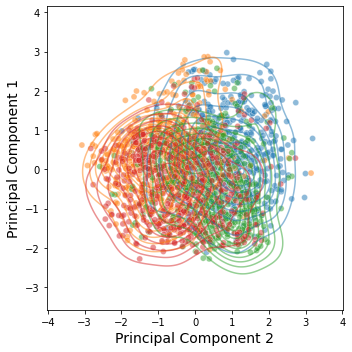

In [223]:
### Figure: PCA results
fig, axs = plt.subplots(1,1,figsize=(5,5))
ax = axs
sns.scatterplot(x="pc1", y="pc2", data=perturbed, hue='Circuit', ax=ax, legend=False, alpha=0.5)
sns.kdeplot(data=background, x="pc1", y="pc2", hue="Circuit", thresh=.1, ax=ax, alpha=0.5, legend=False)
ax.set_ylabel('Principal Component 1', fontsize=14)
ax.set_xlabel('Principal Component 2', fontsize=14)
fig.tight_layout()
fig.savefig('kinetic_perturbation_pca.png', dpi=300)

#### Growth Condition Robustness

In [5]:
background = total_background.loc[total_background['index'] == 999]
influx = pd.read_csv('gc_influx_total.csv')
influx = influx.loc[influx['index'] == 999]
export = pd.read_csv('gc_export_total.csv')
export = export.loc[export['index'] == 999]

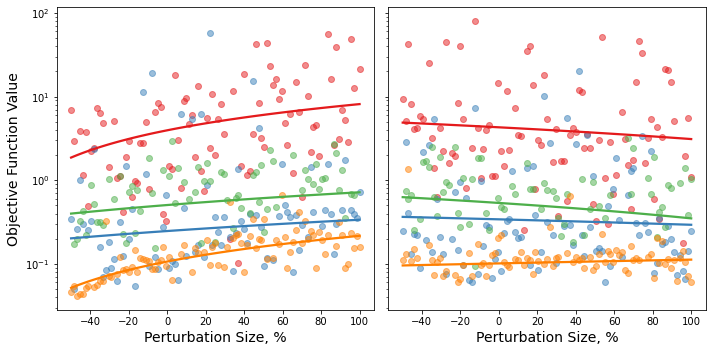

In [23]:
### Figure: Influx scan
archs = ['Open Loop', 'Upstream Repression', 'Downstream Activation', 'Dual Control']
colors = [(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726), (1.0, 0.4980392156862745, 0.0)]

export['scaledperturb']= 100*(export.perturbation - 1)/1
influx['scaledperturb']= 100*(influx.perturbation - 1)/1

fig, axs = plt.subplots(1,2,figsize=(10, 5), sharey=True)
for i in range(4):
    ax = axs[0]
    sns.regplot(data=influx.loc[influx.Circuit == archs[i]], x="scaledperturb", y="best_losses", ax=ax, 
                ci=None, order=1, color=colors[i], robust=True, scatter_kws={'alpha':0.5})
    ax.set_yscale('log')
    ax.set_ylabel('Objective Function Value', fontsize=14)
    ax.set_xlabel('Perturbation Size, %', fontsize=14)

    ax = axs[1]
    sns.regplot(data=export.loc[export.Circuit == archs[i]], x="scaledperturb", y="best_losses",  ax=ax, 
                ci=None, order=1, color=colors[i], robust=True, scatter_kws={'alpha':0.5})
    ax.set_yscale('log')
    ax.set_ylabel('')
    ax.set_xlabel('Perturbation Size, %', fontsize=14)


fig.tight_layout()
fig.savefig('growth_condition_robustness.png', dpi=300)